In [112]:
from body_matrix import load
from body_matrix import infer
from body_matrix import process

video, frame_counts, fps, sample_frame = load.video(
    "/Users/troydo42/Desktop/Body_Matrixes/samples/man_01.mp4", 
    90, 
    1
)

keypoints_model, keypoints_transform = load.keypoints_model("cpu")
selected_box, keypoints = infer.detect_main_target(
    sample_frame, "cpu", 0.8, keypoints_model, keypoints_transform
)
selected_kps = process.keypoints_filter(
    [
        'left_shoulder','right_shoulder', 
        'left_hip', 'right_hip',  
        'left_elbow','right_elbow',
        'left_wrist', 'right_wrist',
        'left_ankle', 'right_ankle'], 
    keypoints
)

segment_model, segment_transform = load.segment_model("cpu")
mask, mask_image, bool_mask = infer.segment_selected_target(
    sample_frame, "cpu", selected_box, 0.9, segment_model, segment_transform
)

segment_area = process.segmentation_area(
    sample_frame, 
    bool_mask
)

Found  1  person in the frame
Distances:  [36.484947204589844]
Areas:  [189190.37870431272]
FOCUSES:  [5185.436548487382]
Select keypoint index 0
Found  1  person in the frame
[190.65017700195312, 444.9407043457031, 448.255859375, 1197.6370849609375]
[196.6202850341797, 452.7583923339844, 450.4098205566406, 1198.2200927734375]
[5.843205253304225]
5.843205253304225 0


In [113]:
print(selected_kps)

{'left_shoulder': [237.32237243652344, 588.5149536132812], 'right_shoulder': [373.31524658203125, 585.63671875], 'left_elbow': [213.37997436523438, 692.1312255859375], 'right_elbow': [418.3269958496094, 694.0501098632812], 'left_wrist': [245.941650390625, 757.3711547851562], 'right_wrist': [427.9039611816406, 795.7474975585938], 'left_hip': [268.9263610839844, 811.0980834960938], 'right_hip': [359.9075012207031, 812.0574951171875], 'left_ankle': [290.953369140625, 1155.5263671875], 'right_ankle': [349.37286376953125, 1105.6370849609375]}


In [114]:
ls = selected_kps['left_shoulder']
rs = selected_kps['right_shoulder']

def two_points_linear_constant(a, b):
    aX = a[0]
    aY = a[1]
    bX = b[0]
    bY = b[1]
    alpha = (bY - aY)/(bX - aX)
    beta = (bX * aY - bY * aX)/(bX - aX)
    return alpha, beta

alpha, beta = two_points_linear_constant(ls, rs)
print(alpha, beta)

-0.02116460058195134 593.5377868350614


In [115]:
def find_segment_line(segment_area, alpha, beta):
    line_coordinates = []
    
    for idx, position in enumerate(sorted(segment_area)):
        expectedY = alpha * position[0] + beta
        if position[1] == int(expectedY):
            line_coordinates.append(
                [position[0], position[1]]
            )
    return line_coordinates

In [116]:
shoulder_line_coordinates = find_segment_line(segment_area, alpha, beta)
shoulder_line_coordinates

[[213, 589],
 [214, 589],
 [215, 588],
 [216, 588],
 [217, 588],
 [218, 588],
 [219, 588],
 [220, 588],
 [221, 588],
 [222, 588],
 [223, 588],
 [224, 588],
 [225, 588],
 [226, 588],
 [227, 588],
 [228, 588],
 [229, 588],
 [230, 588],
 [231, 588],
 [232, 588],
 [233, 588],
 [234, 588],
 [235, 588],
 [236, 588],
 [237, 588],
 [238, 588],
 [239, 588],
 [240, 588],
 [241, 588],
 [242, 588],
 [243, 588],
 [244, 588],
 [245, 588],
 [246, 588],
 [247, 588],
 [248, 588],
 [249, 588],
 [250, 588],
 [251, 588],
 [252, 588],
 [253, 588],
 [254, 588],
 [255, 588],
 [256, 588],
 [257, 588],
 [258, 588],
 [259, 588],
 [260, 588],
 [261, 588],
 [262, 587],
 [263, 587],
 [264, 587],
 [265, 587],
 [266, 587],
 [267, 587],
 [268, 587],
 [269, 587],
 [270, 587],
 [271, 587],
 [272, 587],
 [273, 587],
 [274, 587],
 [275, 587],
 [276, 587],
 [277, 587],
 [278, 587],
 [279, 587],
 [280, 587],
 [281, 587],
 [282, 587],
 [283, 587],
 [284, 587],
 [285, 587],
 [286, 587],
 [287, 587],
 [288, 587],
 [289, 587],

In [117]:
print(ls, rs)

[237.32237243652344, 588.5149536132812] [373.31524658203125, 585.63671875]


In [118]:
if ls[0] < rs[0]:
    print("BACK")
    shoulder_kps = {
        'left_shoulder': shoulder_line_coordinates[0],
        'right_shoulder': shoulder_line_coordinates[-1]
    }

elif ls[0] > rs[0]:
    print("FRONT")
    shoulder_kps = {
        'left_shoulder': shoulder_line_coordinates[-1],
        'right_shoulder': shoulder_line_coordinates[0]
    }
        
        
shoulder_kps

BACK


{'left_shoulder': [213, 589], 'right_shoulder': [403, 585]}

[213, 589]
[403, 585]


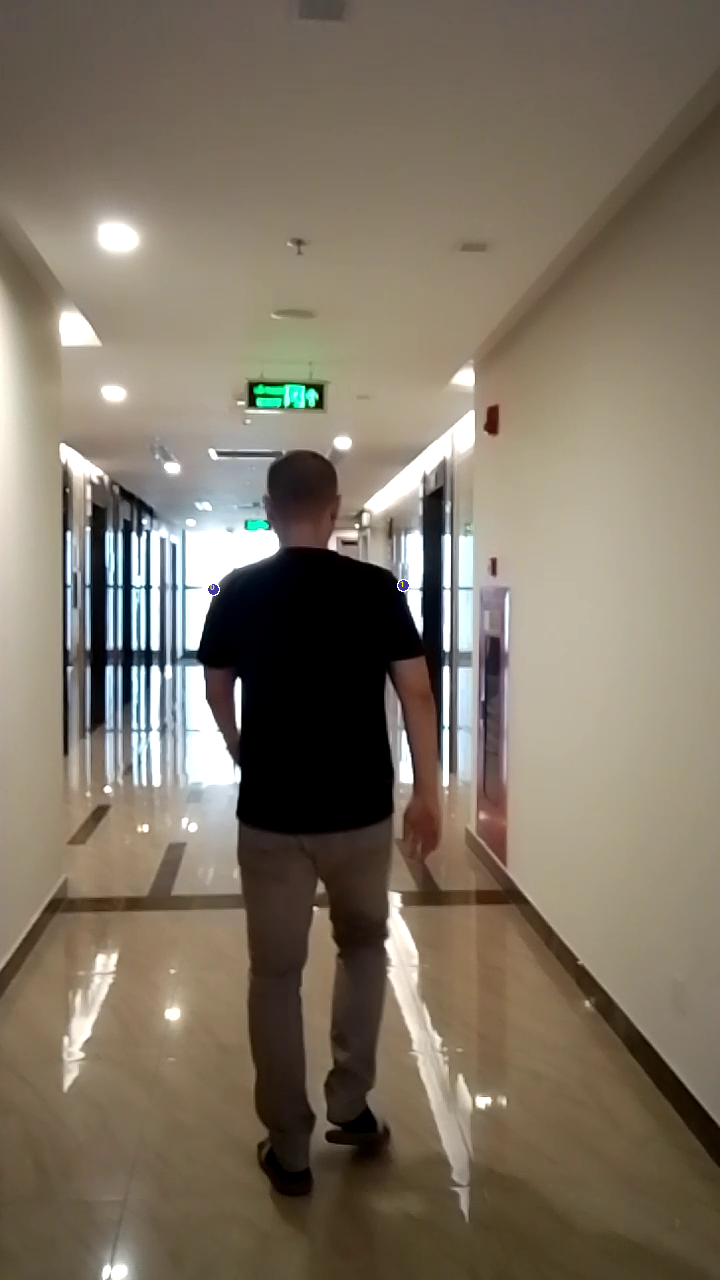

In [119]:
from body_matrix import draw 

output = draw.keypoint_markers(
    coordinates=shoulder_kps,
    image=sample_frame, 
    label_font="/path/Roboto-Bold.ttf"
)
output

In [120]:
from body_matrix import measure

middle_shoulder = measure.find_middle_point(
    shoulder_kps['left_shoulder'], 
    shoulder_kps['right_shoulder']
)

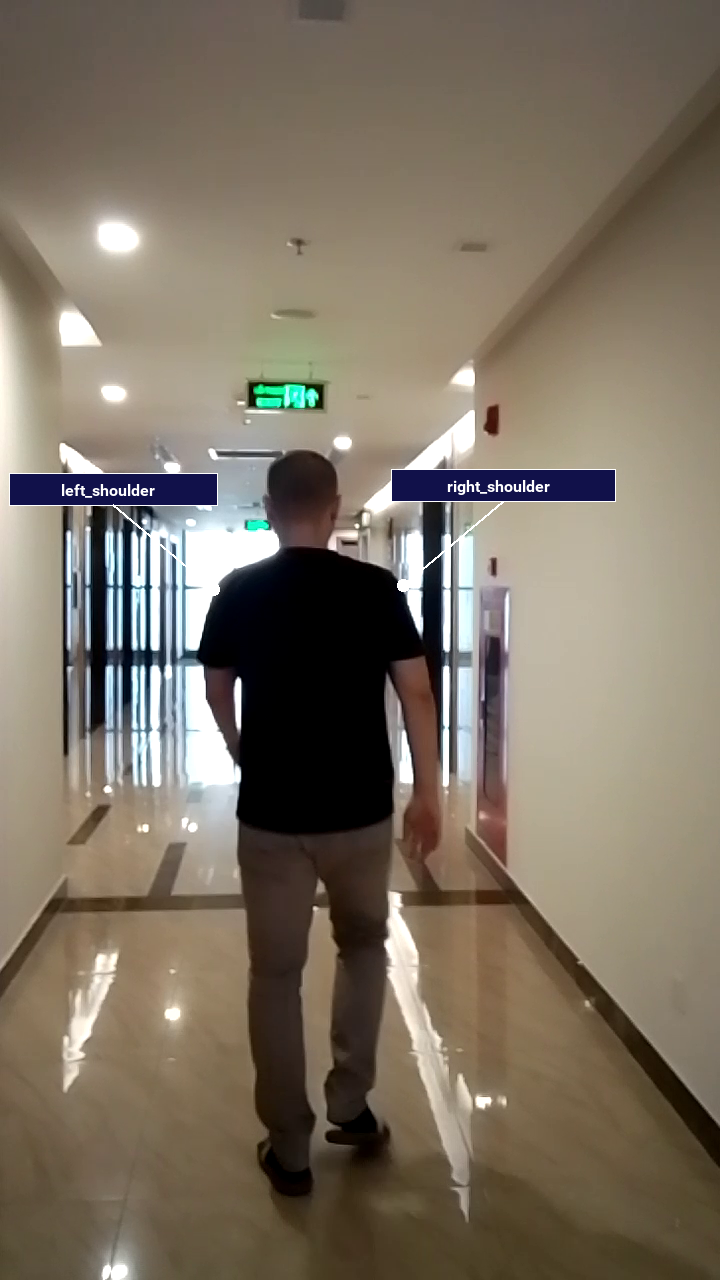

In [121]:
float_sample = sample_frame
for key, value in shoulder_kps.items():
    float_sample = draw.floating_rectangle_label(
        image=float_sample, 
        longitude_coordinate=middle_shoulder[0],
        point=value, 
        label_text=key, 
        label_size=16, 
        label_color="#ffffff", 
        label_font="/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf",
        background_color="#11114A"
    ) 
    
float_sample

In [122]:
hip_alpha, hip_beta = two_points_linear_constant(
    selected_kps['left_hip'], 
    selected_kps['right_hip']
)

print(hip_alpha, hip_beta)

0.010545170346865598 808.2622092077005


In [123]:
hip_line_coordinates = find_segment_line(segment_area, hip_alpha, hip_beta)
hip_line_coordinates

[[235, 810],
 [236, 810],
 [237, 810],
 [238, 810],
 [239, 810],
 [240, 810],
 [241, 810],
 [242, 810],
 [243, 810],
 [244, 810],
 [245, 810],
 [246, 810],
 [247, 810],
 [248, 810],
 [249, 810],
 [250, 810],
 [251, 810],
 [252, 810],
 [253, 810],
 [254, 810],
 [255, 810],
 [256, 810],
 [257, 810],
 [258, 810],
 [259, 810],
 [260, 811],
 [261, 811],
 [262, 811],
 [263, 811],
 [264, 811],
 [265, 811],
 [266, 811],
 [267, 811],
 [268, 811],
 [269, 811],
 [270, 811],
 [271, 811],
 [272, 811],
 [273, 811],
 [274, 811],
 [275, 811],
 [276, 811],
 [277, 811],
 [278, 811],
 [279, 811],
 [280, 811],
 [281, 811],
 [282, 811],
 [283, 811],
 [284, 811],
 [285, 811],
 [286, 811],
 [287, 811],
 [288, 811],
 [289, 811],
 [290, 811],
 [291, 811],
 [292, 811],
 [293, 811],
 [294, 811],
 [295, 811],
 [296, 811],
 [297, 811],
 [298, 811],
 [299, 811],
 [300, 811],
 [301, 811],
 [302, 811],
 [303, 811],
 [304, 811],
 [305, 811],
 [306, 811],
 [307, 811],
 [308, 811],
 [309, 811],
 [310, 811],
 [311, 811],

In [100]:
lh = selected_kps['left_hip']
rh = selected_kps['right_hip']
lw = selected_kps['left_wrist']
rw = selected_kps['right_wrist']
middle_hip = measure.find_middle_point(
    lh, rh
)

print(middle_hip, lw, rw, lh, rh)

(319.41038513183594, 749.3610229492188) [378.8851318359375, 725.3779296875] [239.79100036621094, 741.6864013671875] [345.3106689453125, 748.4016723632812] [293.5101013183594, 750.3203735351562]


In [101]:
if lw[1] > lh[1]:
    precise_rh = hip_line_coordinates[-1]
    precise_lhX = 2 * middle_hip[0] - rh[0]
    precise_lhY = hip_alpha * precise_lhX + hip_beta
    precise_lh = [int(precise_lhX), int(precise_lhY)]
    hip_kps = {
        'left_hip': precise_lh,
        'right_hip': precise_rh
    }
    print("low left hand", hip_kps)
    
elif rw[1] > rh[1]:
    precise_lh = hip_line_coordinates[0]
    precise_rhX = 2 * middle_hip[0] - precise_lh[0]
    precise_rhY = hip_alpha * precise_rhX + hip_beta
    precise_rh = [int(precise_rhX), int(precise_rhY)] 
    
    hip_kps = {
        'left_hip': precise_lh,
        'right_hip': precise_rh
    }
    print("low right hand", hip_kps)
    
else:
    hip_kps = {
        'left_hip': hip_line_coordinates[0],
        'right_hip': hip_line_coordinates[-1]
    }
    print("both hand high", hip_kps)

both hand high {'left_hip': [384, 746], 'right_hip': [248, 752]}


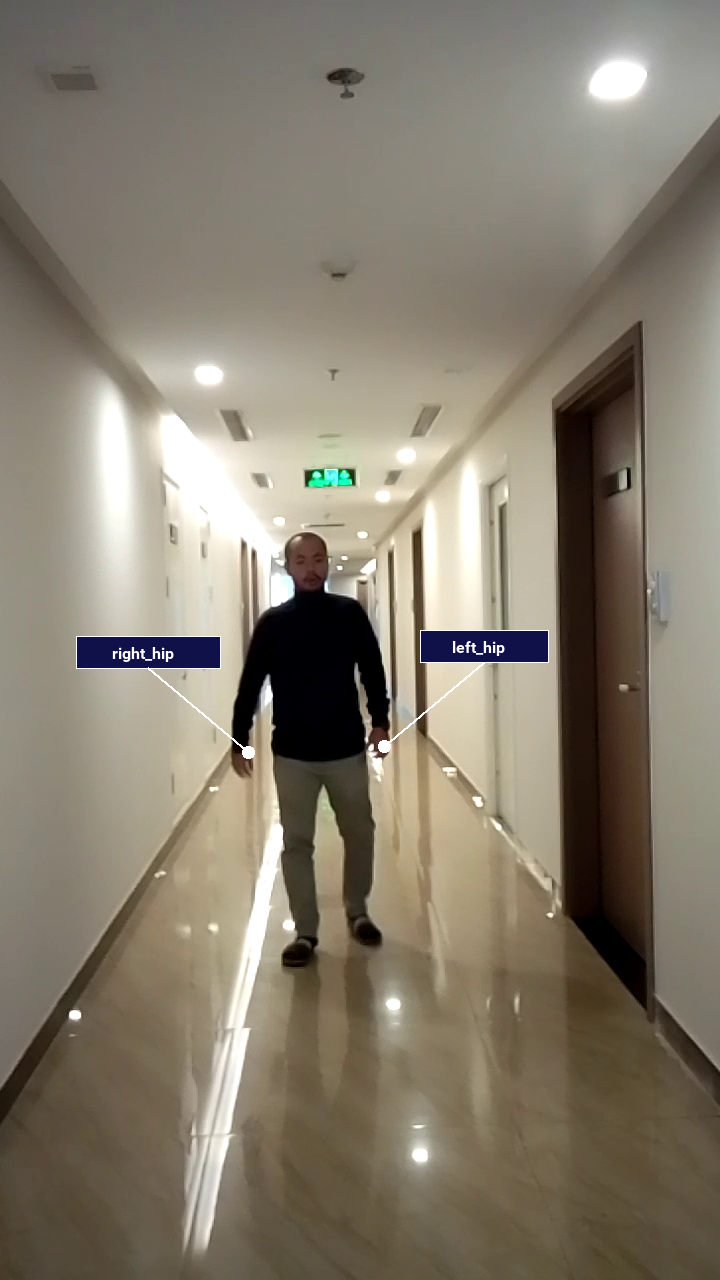

In [102]:
hip_sample = sample_frame

for key, value in hip_kps.items():
    hip_sample = draw.floating_rectangle_label(
        image=hip_sample, 
        longitude_coordinate=middle_shoulder[0],
        point=value, 
        label_text=key, 
        label_size=16, 
        label_color="#ffffff", 
        label_font="/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf",
        background_color="#11114A"
    )

hip_sample